# Character Level RNN using LSTM cells.

- Trains on Star Trek episode titles
- Outputs "fake" titles.

Much comes from a [Keras example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

## Setup Environment

- Import Keras
- Open up the Star Trek corpus
- We need to translate the textual data into a format that the RNN can accept as input.
- Give each letter an index and create dictionaries to translate from index to character.

In [2]:
## Much borrowed from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

from keras.callbacks import LambdaCallback
import numpy as np
import random
import sys

text = open("startrekepisodes.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print('total chars:', vocabulary_size)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


# How long is a title?
titles = text.split('\n')
lengths = np.array([len(n) for n in titles])
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Min:", np.min(lengths))

# hence choose 30 as seuence length to train on.
print("Character Dictionary: ", char_indices)
print("Inverse Character Dictionary: ", indices_char)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


corpus length: 11010
total chars: 49
Max: 50
Mean: 14.001362397820163
Median: 13.0
Min: 2
Character Dictionary:  {'2': 11, '!': 2, 'x': 43, ')': 5, '.': 8, 'à': 46, '7': 15, 'h': 27, 'f': 25, 'z': 45, 'n': 33, '0': 9, ',': 6, 'r': 37, 'i': 28, 'k': 30, 'e': 24, '?': 19, 'c': 22, '1': 10, 'j': 29, '8': 16, '5': 14, 't': 39, 'u': 40, '9': 17, 'p': 35, 'm': 32, 'd': 23, 'g': 26, '4': 13, 'y': 44, ' ': 1, 'l': 31, 'w': 42, 'q': 36, ':': 18, '-': 7, 'b': 21, 's': 38, 'é': 47, '’': 48, '\n': 0, 'o': 34, "'": 3, '3': 12, '(': 4, 'v': 41, 'a': 20}
Inverse Character Dictionary:  {0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '7', 16: '8', 17: '9', 18: ':', 19: '?', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z', 46: 'à', 47: 'é',

## Setup Training Data

- Cut up the corpus into semi-redundant sequences of 30 characters.
- Change indices into "one-hot" vector encodings.

<img src="figures/slicing_text.png",width=600>

In [3]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 30
step = 3

sentences = [] #The training data
next_chars = [] #The training labels

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

print(sentences[0])
print(next_chars[0])

nb sequences: 3660
the man trap
charlie x
where n
o


### Onehot encoding:
* a -> [1, 0, 0, ..., 0]
* b -> [0, 1, 0, ..., 0]
* ...

Each training sample becomes 2D tensor:
* "This is the text" -> X = [[0, 0, ..., 1, 0, ..., 0], ..., [0, 0, ..., 1, 0, ... 0]]

Each target (next letter) becomes 1D onehot tensor:
* a -> y = [1, 0, 0, ..., 0]

In [35]:
#X shape: 3D tensor. First dimension is the sentences, second is each letter in each sentence, third is the onehot
#vector representing that letter.
X = np.zeros((len(sentences), maxlen, vocabulary_size), dtype=np.bool)
y = np.zeros((len(sentences), vocabulary_size), dtype=np.bool)
    
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print("Done preparing training corpus, shapes of sets are:")
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
print("Vocabulary of characters:", vocabulary_size)

Done preparing training corpus, shapes of sets are:
X shape: (3660, 30, 49)
y shape: (3660, 49)
Vocabulary of characters: 49


## Model

- Model has one hidden layer of 128 LSTM cells.
- Output layer uses the "softmax" activation function to output a probability distribution over next letters.

<img src="figures/n-in-1-out.png",width=800>

In [36]:
#TODO: Cut out of skeleton.

layer_size = 128
# build the model: a single LSTM
model_train = Sequential()

model_train.add(LSTM(layer_size, input_shape=(maxlen, len(chars))))
# Project back to vocabulary. One output node for each letter.
# Dense indicates a fully connected layer.
# Softmax activation ensures the combined values of all outputs form a probability distribution:
# They sum to 1, with each individual value between 0 and 1.
model_train.add(Dense(len(chars), activation='softmax'))


In [37]:
# Categorical crossentropy  minimizes the distance between the probability distributions 
# output by the network and the true distribution of the targets.
# The optimizer specifies HOW the gradient of the loss will be used to update parameters.
# Different optimizers have different tricks to avoid local optima, etc.
# RMSProp is adaptive, adjusting the rate of learning to how fast we're currently learning.
# Choose one by experimenting, or selecting one documented to work well for this problem by other researchers.
model_train.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_train.summary()

# LSTM is more complicated than the basic RNN we introduced. It has more free parameters, therefore more parameters 
# than one might expect below. We use them since they are better at learning long-term structure.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               91136     
_________________________________________________________________
dense_8 (Dense)              (None, 49)                6321      
Total params: 97,457
Trainable params: 97,457
Non-trainable params: 0
_________________________________________________________________


<img src="figures/reweighting.png",width=800>

In [38]:
## Sampling function - maybe keep this in skeleton?

#Higher diversity -> more randomness in the generation.
def sample(probability_distribution, diversity=1.0):
    # helper function to sample an index from a probability distribution
    probability_distribution = np.asarray(probability_distribution).astype('float64')
    probability_distribution = np.log(probability_distribution) / diversity
    exp_preds = np.exp(probability_distribution)
    probability_distribution = exp_preds / np.sum(exp_preds)
    #Draws 1 element at random according to the new scaled probability-distribution.
    probabilities = np.random.multinomial(n=1, pvals = probability_distribution) 
    return np.argmax(probabilities)

## Method for printing some example text after every epoch

In [39]:
def generate_text_segment(length, diversity, generating_model = model_train, input_sequence_length = maxlen):
    start_index = random.randint(0, len(text) - input_sequence_length - 1)

    # We need a seed to start the text generation. Since during training the ANN always experiences
    # sentences of size 30, we seed it with a sentence of length 30 to get it into a sensible state.
    generated = ''
    sentence = text[start_index: start_index + input_sequence_length]
    generated += sentence
    
    sys.stdout.write('----- Generating with seed: "' + sentence + '"')

    for i in range(length):
        x_pred = np.zeros((1, input_sequence_length, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        

        predictions_distribution = generating_model.predict(x_pred, verbose=0)[0]
        next_index = sample(predictions_distribution, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        #Stepping one symbol forward in the sentence
        sentence = sentence[1:] + next_char

    return generated

In [40]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    for diversity in [0.5]:#[0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = generate_text_segment(400, diversity, model_train, input_sequence_length = maxlen)
        sys.stdout.write(generated)
        print()
        

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

## Training

- Train on batches of 128 examples

In [41]:
# Training the Model. history captures data for plotting (e.g loss)
# Kai: The default Keras "progress bar" made my notebook freeze. this keras-tqdm fixes that.
# Installed with pip install keras-tqdm.
from keras_tqdm import TQDMNotebookCallback
print("training start")
history = model_train.fit(X, y, batch_size=128, epochs=20, verbose=0, callbacks=[print_callback,TQDMNotebookCallback()])
print("Training done")
#TODO: Ask Charles: Any motivation for this batch size? What does batch size mean exactly in this setting?

training start

----- Generating text after Epoch: 0
----- diversity: 0.5
----- Generating with seed: " crossing
judgment
horizon
the" crossing
judgment
horizon
the e re o scr at t ernr ae

 tcin
 eo har p   h srreerniaih ia  reifc trg el  iaeate ethreet  hone ra  r  ran   
t r ia
rar orr n rmr or ohc 
rerrararaateee rto hea
 te e  t tn enrrronentoeottere  rt  rhr ire eeceeoa n reas ee  h r
aar i
crteettra o ai e  re
t 
totoe
eert o eino  ehat areeneero
 a  r 
 ar
re   aaarr
oearee eh n ar  e r  ri nu  tt tatn
 ht e  oa ird n   r  
ar on e  nehec e e vece te

----- Generating text after Epoch: 1
----- diversity: 0.5
----- Generating with seed: "i
past prologue
a man alone
ba"i
past prologue
a man alone
bartor tee tel lrr iirl t ot e rt eecorereo cor
taret e t rde oorgort eter
tor
ooro ooret rorerir
the bere rir t p otede bot t oncorortte
tore
enlore

oetre t mort er
o
t toorre ohere the tho ror dor
te
o
t o the
the pore e oor the the oerd too t f c lert re t
role tare deree oeremotor
e

In [30]:
# Save model if necessary
model_train.save("keras-startrek-LSTM-model.h5")

## Plotting training and validation error

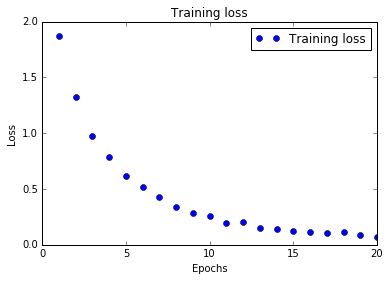

In [31]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make a Decoder model

During training, we presented sequences of 30 characters, along with the correct next character.
When_using the trained model, it may be more useful to feed in 1 character at a time, and seeing the next
predicted one. That will also convince us that the network is actually _using_ its internal state.

- Needs input length of 1.
- Needs batch size of 1
- Needs LSTM to be stateful
- check that params is the same as model_train

<img src="figures/1-in-1-out.png",width=800>

In [ ]:
# Load model if necessary.
model_train = load_model("keras-startrek-LSTM-model.h5")

In [ ]:
# Build a decoding model (input length 1, batch size 1, stateful)
layer_size = 128

model_dec = Sequential()
# 1 letter in, 1 letter out.
# Stateful=True keeps the state from the end of one batch to the start of the next
# In other words, the network "remembers" its state from one input to the next. This is essential when
# the network looks at 1 input at a time.
model_dec.add(LSTM(layer_size, stateful=True, batch_input_shape=(1,1,len(chars))))

# project back to vocabulary
model_dec.add(Dense(vocabulary_size, activation='softmax'))
model_dec.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_dec.summary()

# set weights from training model
# Note that we can reuse these weights, since the sizes of the trained and decoder network are the same.
# The trained network took in 30 characters, but remember that all these 30 used the same input weights.
# That is one of the advantages of RNNs: They are independent of sequence lengths.
model_dec.set_weights(model_train.get_weights())

## Test the Model

- Take a quote then add 400 characters.

In [ ]:
# Sample 1000 characters from the decoding model using a random seed from the vocabulary.
generated = generate_text_segment(1000, diversity=0.5, generating_model = model_dec, input_sequence_length = 1)
sys.stdout.write(generated)
print()